In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import os
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

In [2]:
backcandles = 100

#### load data from files and merge them into one dataframe

BTCUSDT.csv


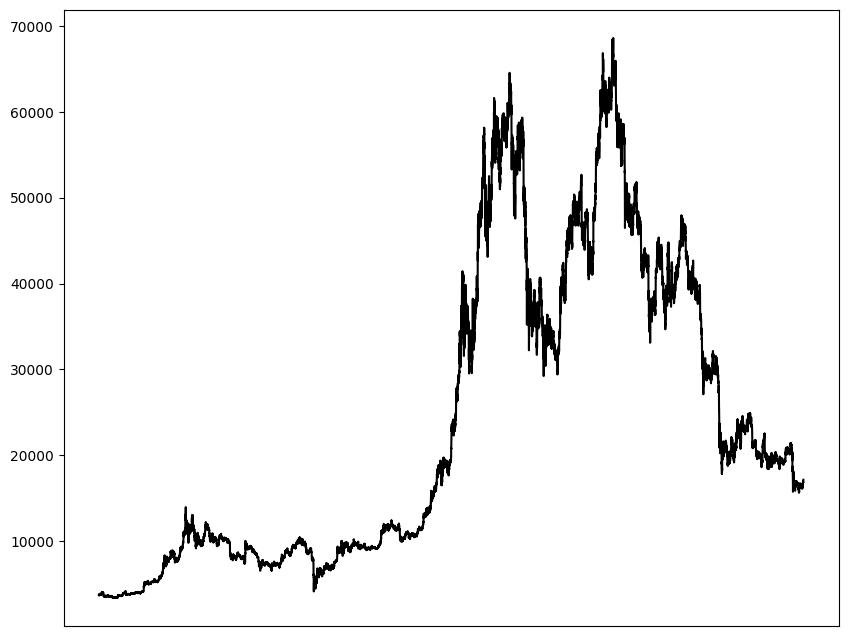

In [3]:
df = pd.DataFrame()
folder_path = 'data'
for file_name in ['BTCUSDT.csv']:
    if os.path.isfile(os.path.join(folder_path, file_name)):
        print(file_name)
        sample = pd.read_csv(f"{folder_path}/{file_name}")
        sample['ticker'] = file_name
        
        plt.figure(figsize=(10,8))
        plt.plot([i for i in range(len(sample))], sample.Close, color = 'black', label = 'real')
        plt.xticks([])
        plt.show()
        
        df = pd.concat([df,sample], axis=0)

In [4]:
df

,Close,High,Low,Transactions,Open,Timestamp,Volume,ticker,date,time,answer
0,3700.31,3713.00,3689.88,5534,3701.23,2019-01-01 00:00:00,686.367420,BTCUSDT.csv,2019-01-01,00:00:00,3689.69
1,3689.69,3702.73,3684.22,5086,3700.20,2019-01-01 01:00:00,613.539115,BTCUSDT.csv,2019-01-01,01:00:00,3690.00
2,3690.00,3695.95,3675.04,6391,3689.67,2019-01-01 02:00:00,895.302181,BTCUSDT.csv,2019-01-01,02:00:00,3693.13
3,3693.13,3699.77,3685.78,5709,3690.00,2019-01-01 03:00:00,796.714818,BTCUSDT.csv,2019-01-01,03:00:00,3692.71
4,3692.71,3720.00,3685.94,7908,3692.32,2019-01-01 04:00:00,1317.452909,BTCUSDT.csv,2019-01-01,04:00:00,3699.94
...,...,...,...,...,...,...,...,...,...,...,...
34256,16921.44,16986.00,16705.00,437117,16789.66,2022-11-30 18:00:00,20627.657320,BTCUSDT.csv,2022-11-30,18:00:00,17062.85
34257,17062.85,17147.16,16917.30,517212,16920.45,2022-11-30 19:00:00,23959.641700,BTCUSDT.csv,2022-11-30,19:00:00,17097.19
34258,17097.19,17103.52,17030.21,232781,17061.14,2022-11-30 20:00:00,10883.041700,BTCUSDT.csv,2022-11-30,20:00:00,17106.65
34259,17106.65,17111.70,17028.37,221837,17098.37,2022-11-30 21:00:00,10824.192860,BTCUSDT.csv,2022-11-30,21:00:00,17148.29


In [5]:
df['ticker'].value_counts()

ticker
BTCUSDT.csv    34261
Name: count, dtype: int64

#### drop unuseful columns

In [6]:
df.drop(['date','time','answer','ticker', 'Timestamp'], axis=1, inplace=True)
df

,Close,High,Low,Transactions,Open,Volume
0,3700.31,3713.00,3689.88,5534,3701.23,686.367420
1,3689.69,3702.73,3684.22,5086,3700.20,613.539115
2,3690.00,3695.95,3675.04,6391,3689.67,895.302181
3,3693.13,3699.77,3685.78,5709,3690.00,796.714818
4,3692.71,3720.00,3685.94,7908,3692.32,1317.452909
...,...,...,...,...,...,...
34256,16921.44,16986.00,16705.00,437117,16789.66,20627.657320
34257,17062.85,17147.16,16917.30,517212,16920.45,23959.641700
34258,17097.19,17103.52,17030.21,232781,17061.14,10883.041700
34259,17106.65,17111.70,17028.37,221837,17098.37,10824.192860


#### feature engeneering

In [7]:
df['RSI']=ta.rsi(df.Close, length=15)
df['EMAF']=ta.ema(df.Close, length=20)
df['EMAM']=ta.ema(df.Close, length=100)
df['EMAS']=ta.ema(df.Close, length=150)

In [8]:
df['NextClose'] = df['Close'].shift(-1)

In [9]:
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df

,Close,High,Low,Transactions,Open,Volume,RSI,EMAF,EMAM,EMAS,NextClose
0,3994.96,3996.08,3980.08,6484,3987.89,732.657805,69.455883,3935.527967,3828.565056,3794.025267,3990.78
1,3990.78,4001.77,3982.61,7383,3993.82,1105.659213,68.180056,3940.790065,3831.777233,3796.631290,4001.00
2,4001.00,4001.21,3988.00,7863,3990.76,1113.761223,69.640918,3946.524345,3835.128179,3799.338160,4007.70
3,4007.70,4015.00,3990.00,10398,4001.02,2023.906550,70.589340,3952.350598,3838.545442,3802.097919,3957.01
4,3957.01,4010.67,3921.53,19703,4007.68,4055.909859,56.325699,3952.794350,3840.891275,3804.149735,3959.35
...,...,...,...,...,...,...,...,...,...,...,...
34106,16789.66,16876.52,16720.56,282062,16861.98,12003.127580,55.425123,16779.337869,16543.509550,16517.839393,16921.44
34107,16921.44,16986.00,16705.00,437117,16789.66,20627.657320,63.338715,16792.871405,16550.993321,16523.185096,17062.85
34108,17062.85,17147.16,16917.30,517212,16920.45,23959.641700,69.553365,16818.583652,16561.129097,16530.332976,17097.19
34109,17097.19,17103.52,17030.21,232781,17061.14,10883.041700,70.839502,16845.117590,16571.744165,16537.841016,17106.65


#### split dataset into features and target

In [10]:
target = ['NextClose']
features = df.columns.drop(target)
features

Index(['Close', 'High', 'Low', 'Transactions', 'Open', 'Volume', 'RSI', 'EMAF',
       'EMAM', 'EMAS'],
      dtype='object')

In [11]:
X = df[features]
y = df[target]

#### scaling

In [12]:
scaler_x, scaler_y = MinMaxScaler(), MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [13]:
X_scaled.shape

(34111, 10)

#### create slices

In [14]:
X_full = []

for j in range(10):
    X_full.append([])
    for i in range(backcandles, X_scaled.shape[0]):
        X_full[j].append(X_scaled[i-backcandles:i, j])

X_full = np.moveaxis(X_full, [0], [2])
X_full = np.array(X_full)

y_full = np.array(y_scaled[backcandles:])
y_full = y_full.reshape(-1,1)

In [15]:
X_full.shape, y_full.shape

((34011, 100, 10), (34011, 1))

#### split dataset into train and test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, shuffle=False)

In [17]:
X_train.shape, X_test.shape

((27208, 100, 10), (6803, 100, 10))

#### LSTM model building

In [18]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

C:\Users\natal\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          44,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,501 (173.83 KB)

 Trainable params: 44,501 (173.83 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
adam = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss='mse')
model.fit(x = X_train, y = y_train, batch_size=256, epochs=10, shuffle=True, validation_split = 0.15)

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 254ms/step - loss: 0.0456 - val_loss: 2.4059e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 24s 263ms/step - loss: 6.8862e-04 - val_loss: 1.6101e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - loss: 4.4003e-04 - val_loss: 1.6457e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - loss: 3.9539e-04 - val_loss: 1.8259e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - loss: 4.0405e-04 - val_loss: 3.1521e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - loss: 3.8865e-04 - val_loss: 2.8744e-04
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - loss: 3.5767e-04 - val_loss: 2.2089e-04
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - loss: 3.0644e-04 - val_loss: 4.5369e-04
Epoch 9/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - loss: 3.2232e-04 - val_loss: 2.4992e-04
Epoch 10/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - loss: 2.8054e-04 - val_loss: 7.5199e-04


#### model predict

In [20]:
y_pred = model.predict(X_test)

213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step


In [21]:
y_pred.shape

(6803, 1)

In [22]:
fin_data = pd.DataFrame()

In [23]:
#fin_data['Timestamp'] = pd.DataFrame(df.loc[l+100:].Timestamp).reset_index(drop=True)
fin_data['y_pred'] = pd.DataFrame(y_pred)
fin_data['y_test'] = pd.DataFrame(y_test)

#### inverse transform

In [24]:
fin_data['y_pred_inverce'] = scaler_y.inverse_transform(np.array(fin_data.y_pred).reshape(-1,1))
fin_data['y_test_inverce'] = scaler_y.inverse_transform(np.array(fin_data.y_test).reshape(-1,1))

In [25]:
fin_data

,y_pred,y_test,y_pred_inverce,y_test_inverce
0,0.553890,0.533907,39517.273438,38213.07
1,0.552946,0.533782,39455.710938,38204.92
2,0.552574,0.533660,39431.386719,38196.97
3,0.552278,0.535776,39412.117188,38335.04
4,0.551855,0.534804,39384.468750,38271.61
...,...,...,...,...
6798,0.217467,0.207685,17559.916016,16921.44
6799,0.216900,0.209852,17522.857422,17062.85
6800,0.218387,0.210378,17619.966797,17097.19
6801,0.220158,0.210523,17735.546875,17106.65


#### compare predicted and real data (scaled)

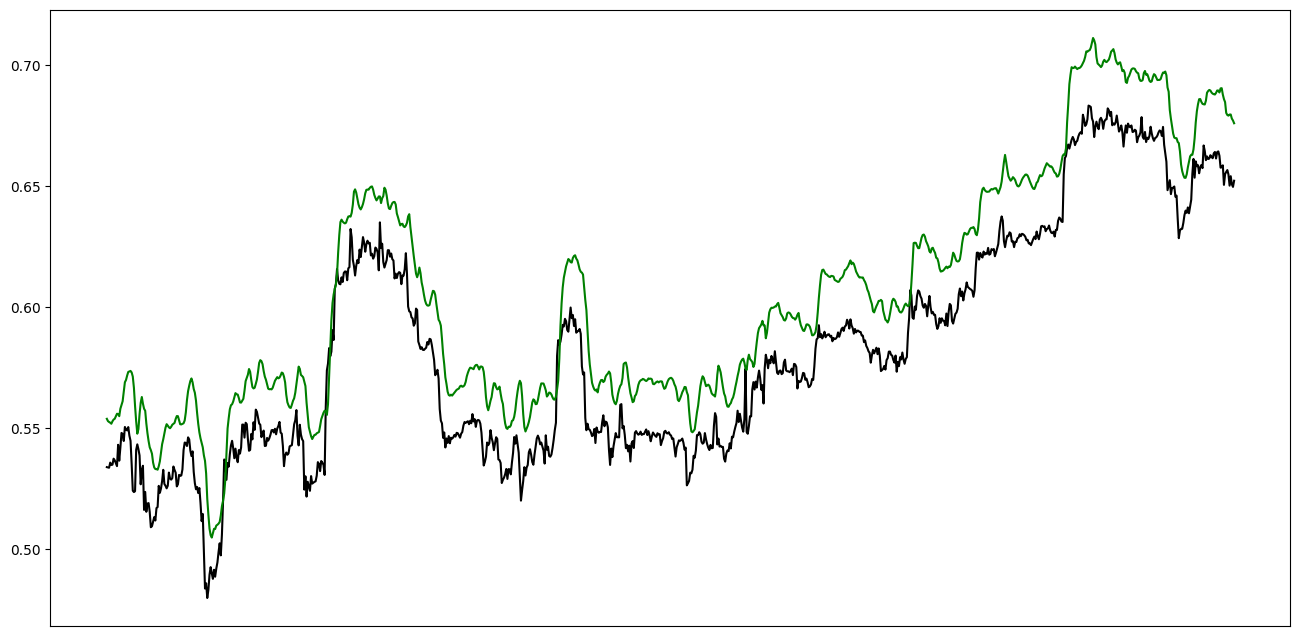

In [27]:
plt.figure(figsize=(16,8))
plt.plot([i for i in range(1000)], fin_data.y_test[:1000], color = 'black', label = 'real')
plt.plot([i for i in range(1000)], fin_data.y_pred[:1000], color = 'green', label = 'pred')
plt.xticks([])
plt.show()

#### compare predicted and real data (inverse transform)

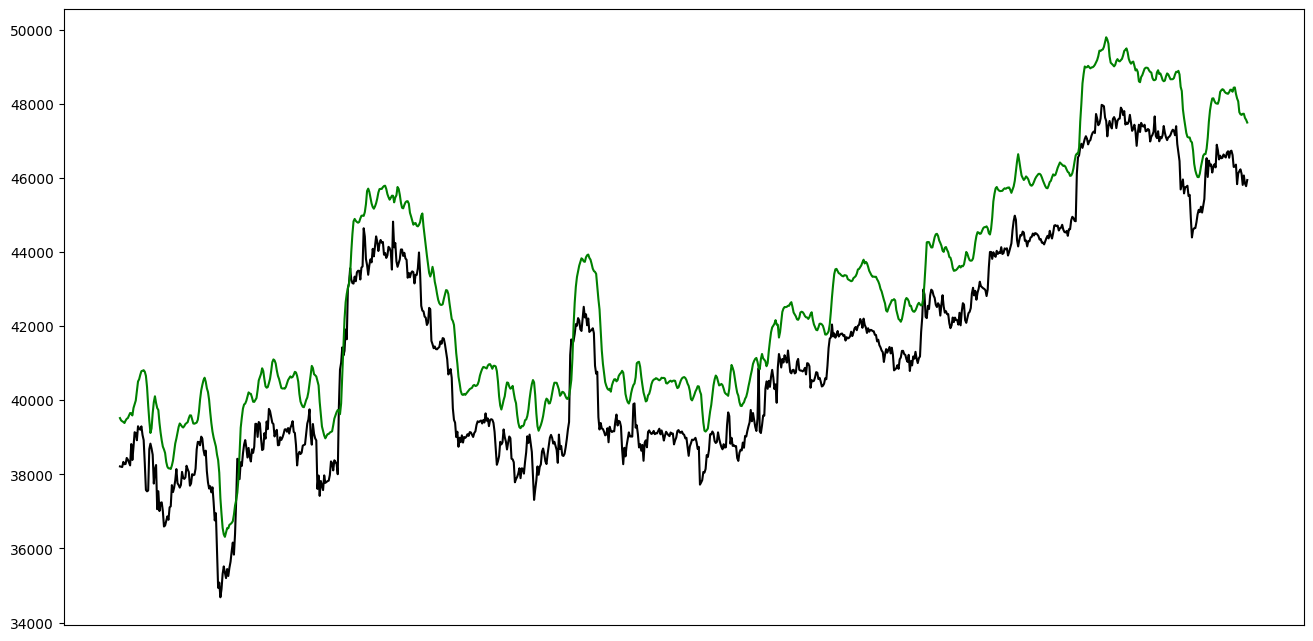

In [28]:
plt.figure(figsize=(16,8))
plt.plot([i for i in range(1000)], fin_data.y_test_inverce[:1000], color = 'black', label = 'real')
plt.plot([i for i in range(1000)], fin_data.y_pred_inverce[:1000], color = 'green', label = 'pred')
plt.xticks([])
plt.show()

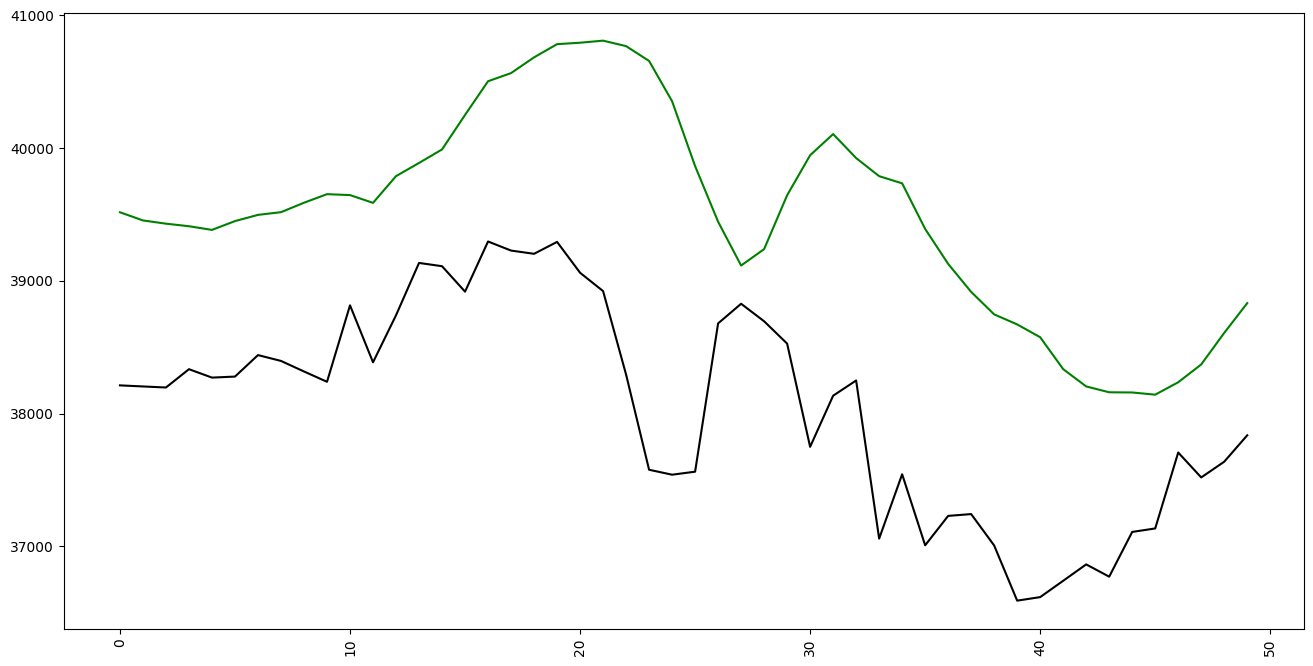

In [31]:
plt.figure(figsize=(16,8))
plt.plot([i for i in range(50)], fin_data.y_test_inverce[:50], color = 'black', label = 'real')
plt.plot([i for i in range(50)], fin_data.y_pred_inverce[:50], color = 'green', label = 'pred')
plt.xticks(rotation=90)
plt.show()